# Behavior in discrimination-estimation task paradigm

Behavior data summary for Figure 1b-d.

In [1]:
import sys
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/processed/behavior")
utils.download_dataset("data/outputs/behavior")

with open("../data/outputs/behavior/bootstrap_psychometric_curve.pickle", 'rb') as f:
    psych = pickle.load(f)

behavior = pd.read_csv("../data/processed/behavior/behavior.csv")
behavior = behavior[(~np.isnan(behavior['choice'])) & (~np.isnan(behavior['error']))]

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...


----
## Psychometric curve based on discrimination task

In [3]:
n_boostrap = psych['bootstrap0'].shape[-1]

x = np.linspace(-21,21,num=201)
y = np.empty((2,len(x),n_boostrap))
for i_boot in range(n_boostrap): 
    for i_t, v_t in enumerate([1,2]):
        y[i_t,:,i_boot] = utils.psi(x, *psych['bootstrap0'][i_t,:,i_boot])

stim_relative = np.array([-21,-4,0,4,21]) # relative orientations of reference
m_y = np.mean(y,axis=-1)
s_y = np.std(y,axis=-1)
_lb = np.mean(psych['bootstrap_choice'],axis=-1) - np.std(psych['bootstrap_choice'],axis=-1)
_ub = np.mean(psych['bootstrap_choice'],axis=-1) + np.std(psych['bootstrap_choice'],axis=-1)

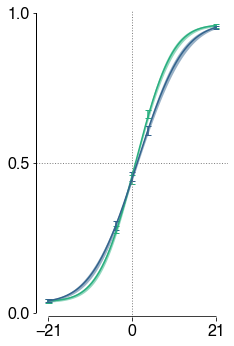

In [4]:
stim_relative = np.array([-21,-4,0,4,21]) # relative orientations of reference

m_y = np.mean(y,axis=-1)
s_y = np.std(y,axis=-1)

plt.figure()
utils.set_size([2.7,3.8])
ax = plt.gca()
plt.axvline(x=0,   linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0.5, linestyle='dotted', color='gray', linewidth=1.)
plt.fill_between(x, m_y[0]-s_y[0], m_y[0]+s_y[0], color=utils.E_COLOR, alpha=0.5, lw=0)
plt.fill_between(x, m_y[1]-s_y[1], m_y[1]+s_y[1], color=utils.L_COLOR, alpha=0.5, lw=0)
plt.plot(x, m_y[0], color=utils.E_COLOR)
plt.plot(x, m_y[1], color=utils.L_COLOR)

plt.vlines(x=stim_relative, ymin=_lb[0], ymax=_ub[0], color=utils.E_COLOR)
plt.hlines(_lb[0], stim_relative-0.8, stim_relative+0.8, color=utils.E_COLOR, linewidth=1)
plt.hlines(_ub[0], stim_relative-0.8, stim_relative+0.8, color=utils.E_COLOR, linewidth=1)

plt.vlines(x=stim_relative, ymin=_lb[1], ymax=_ub[1], color=utils.L_COLOR)
plt.hlines(_lb[1], stim_relative-0.8, stim_relative+0.8, color=utils.L_COLOR, linewidth=1)
plt.hlines(_ub[1], stim_relative-0.8, stim_relative+0.8, color=utils.L_COLOR, linewidth=1)

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(0,1), xticks=[-21,0,21], yticks=[0,0.5,1])
plt.savefig(f'{utils.DIR_FIGURE}/fig1b.pdf',bbox_inches='tight')
plt.show()

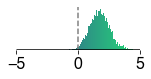

p-value (permutation):  0.0297
95% CI:  [0.22040515 3.4993313 ]


In [5]:
plt.figure()
ax = plt.gca()
utils.set_size([1.8,1])

n_bin   = 160
colors  = []
for v in np.linspace(-0.5,1.5,n_bin):
    colors.append(v*utils.E_COLOR + (1.-v)*utils.L_COLOR)
plt.axvline(x=0, linestyle='dashed', color='gray')
d_bootstrap = psych['bootstrap1'][1][1] - psych['bootstrap1'][0][1]
_, _, patches = plt.hist(d_bootstrap, 
                bins=n_bin, range=(-4.5,4.5), alpha=1., density=True, stacked=True)

for i,p in enumerate(patches):
    plt.setp(p, "facecolor", colors[i])

ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
utils.draw_publish_axis(ax, xrange=(-5,5), yrange=None, xticks=[-5,0,5], yticks=None)
plt.savefig(f'{utils.DIR_FIGURE}/fig1b_inset.pdf',bbox_inches='tight')
plt.show()

ground_truth = psych['ground_truth'][1,1] - psych['ground_truth'][0,1]
null_permute = psych['permutation_null'][1,1] - psych['permutation_null'][0,1]

print('p-value (permutation): ', np.mean((ground_truth < null_permute) | (-ground_truth > null_permute)))
print('95% CI: ', np.percentile(d_bootstrap, [2.5,97.5]))

----
## Stimulus-specific bias based on estimation task

In [6]:
sub_list  = np.sort(behavior.ID.unique())
stim_list = np.sort(behavior.stim.unique())
ssb_list  = np.nan*np.empty((len(sub_list),2,24))
n_stim    = len(stim_list)
n_basis   = 12
p_basis   = n_basis/2.

for i_id, v_id in enumerate(sub_list): 
    idx = (behavior.ID==v_id)
    ssb_list[i_id,0] = [utils.circmean(behavior.error[idx & (behavior.stim==s) & (behavior.Timing==1)]) for s in np.arange(180,step=7.5)]
    ssb_list[i_id,1] = [utils.circmean(behavior.error[idx & (behavior.stim==s) & (behavior.Timing==2)]) for s in np.arange(180,step=7.5)]

# fit weights for each participant
results_e = {}
results_e['info'] = {'n_basis': n_basis, 'p_basis': p_basis}
results_e['weights'] = {}
results_l = {}
results_l['info'] = {'n_basis': n_basis, 'p_basis': p_basis}
results_l['weights'] = {}

In [7]:
np.random.seed(2023)
c_basis   = np.linspace(0, 2*np.pi, n_basis, endpoint = False)
x         = np.linspace(0, 2*np.pi, n_stim,  endpoint = False).reshape((-1,1))
X         = utils.derivative_von_mises(x, c_basis, p_basis)

for i_id, v_id in enumerate(sub_list):
    for i_t, v_t in enumerate([1,2]):
        sub_behav = behavior[(behavior.ID == v_id) & (behavior.Timing == v_t)]
        y         = [utils.circmean(sub_behav.error[sub_behav.stim==s]) for s in stim_list]
        
        # remove nans
        X_nn      = X[~np.isnan(y)]
        y_nn      = np.array(y)[~np.isnan(y)]        
        
        # exception handling (ill-conditioned regression solution for one subject)
        if ((v_id == 54) & (v_t == 1)) | ((v_id == 69) & (v_t == 1)) | ((v_id == 27) & (v_t == 2)):
            y_nn += np.random.normal(scale=0.1,size=y_nn.shape)
            X_nn += np.random.normal(scale=0.1,size=X_nn.shape)
            
        reg = LinearRegression().fit(X_nn,y_nn)
        if i_t == 0:
            results_e['weights'][v_id] = [reg.intercept_, *reg.coef_]
        else:
            results_l['weights'][v_id] = [reg.intercept_, *reg.coef_]

In [8]:
ssb_fun_list = np.nan*np.empty((len(sub_list),2,240))
for i_id, v_id in enumerate(sub_list): 
    ssb_fun_list[i_id,0] = utils.stimulus_specific_bias(np.arange(180,step=0.75), results_e['weights'][v_id], **results_e['info'])
    ssb_fun_list[i_id,1] = utils.stimulus_specific_bias(np.arange(180,step=0.75), results_l['weights'][v_id], **results_l['info'])

m_ssb = np.mean(ssb_list,axis=0)
s_ssb = np.std(ssb_list,axis=0)/np.sqrt(50)
m_ssb_fun = np.mean(ssb_fun_list,axis=0)
s_ssb_fun = np.std(ssb_fun_list,axis=0)/np.sqrt(50)

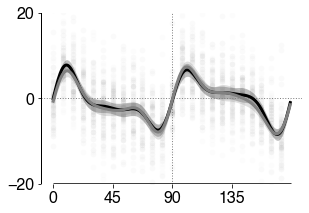

In [9]:
plt.figure()
ax = plt.gca()
utils.set_size([3.5,2.4])

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

for s in range(24): 
    plt.scatter([stim_list[s]]*len(sub_list), ssb_list[:,0,s], alpha=0.02, color='black', linewidth=0)
    plt.scatter([stim_list[s]]*len(sub_list), ssb_list[:,1,s], alpha=0.02, color='gray',  linewidth=0)

plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[0]-s_ssb_fun[0]*1.96, 
                 m_ssb_fun[0]+s_ssb_fun[0]*1.96, 
                 color='black', alpha=0.25, linewidth=0)
plt.plot(np.arange(180,step=0.75), m_ssb_fun[0], color='black', linewidth=3)

plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[1]-s_ssb_fun[1]*1.96, 
                 m_ssb_fun[1]+s_ssb_fun[1]*1.96, 
                 color='gray', alpha=0.25, linewidth=0)
plt.plot(np.arange(180,step=0.75), m_ssb_fun[1], color='gray', linewidth=3)

plt.ylim([-20,20])
plt.xticks([0,45,90,135])
    
if utils.LABEL:
    plt.xlabel(r"Stimulus $(\!\!^\circ\!\!)$")    
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-20,20), xticks=None, yticks=[-20,0,20])
plt.savefig(f'{utils.DIR_FIGURE}/fig1c.pdf', bbox_inches='tight')
plt.show()

---
## Decision-consistent bias

In [10]:
behavior['stim_ref'] = -behavior.ref
behavior['decision'] = 2-behavior['choice']

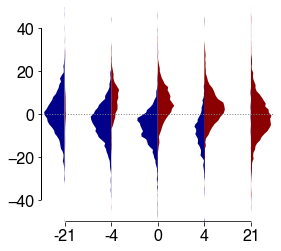

In [11]:
plt.figure()
ax = plt.gca()
utils.set_size([3.2,2.8])

plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)
ax = sns.violinplot(x="stim_ref", y="error", hue="decision", data=behavior[behavior.Timing==1], 
                    split=True, scale='count', linewidth=0, inner=None, 
                    bw=0.08, palette=['darkblue','darkred'], width=0.88, saturation=1)

plt.ylim([-50,50])
plt.xticks(np.arange(5), [-21,-4,0,4,21])
plt.legend([],[], frameon=False)
plt.xlabel('')
plt.ylabel('')

utils.draw_publish_axis(ax, xrange=(0,4), yrange=(-40,40), xticks=None, yticks=[-40,-20,0,20,40])
plt.savefig(f'{utils.DIR_FIGURE}/fig1d_left.pdf',bbox_inches='tight')
plt.show()

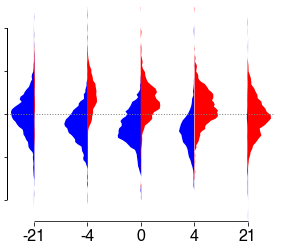

In [12]:
plt.figure()
ax = plt.gca()
utils.set_size([3.2,2.8])

plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)
ax = sns.violinplot(x="stim_ref", y="error", hue="decision", data=behavior[behavior.Timing==2], 
                    split=True, scale='count', linewidth=0, inner=None, 
                    bw=0.08, palette=['blue','red'], width=0.88, saturation=1)

plt.ylim([-50,50])
plt.xticks(np.arange(5), [-21,-4,0,4,21])
plt.legend([],[], frameon=False)
plt.xlabel('')
plt.ylabel('')

ax.set_yticklabels([])
utils.draw_publish_axis(ax, xrange=(0,4), yrange=(-40,40), xticks=None, yticks=[-40,-20,0,20,40])
plt.savefig(f'{utils.DIR_FIGURE}/fig1d_right.pdf',bbox_inches='tight')
plt.show()